## Assignment 2 - Example Solution

### Question 1:

We start with the usual imports.

In [1]:
import numpy as np
import pyopencl as cl

from scipy.sparse.linalg import LinearOperator

In [2]:
import numpy as np
import pyopencl as cl

from scipy.sparse.linalg import LinearOperator

ctx = cl.Context(dev_type=cl.device_type.CPU)
print(ctx.devices[0].name)
mf = cl.mem_flags
queue = cl.CommandQueue(ctx)

Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz


Below we have given an example implementation of the OpenCL based CSR Matrix vector product. It uses AVX2 double precision operations to speed up the parallel matrix vector product. The whole routine is wrapped into a LinearOperator class to allow it to be treated in the same way as normal sparse matrices with respect to matrix/vector products. This was not a requirement though.

The following points are important:

- For high marks the implementation must use vectorized operations as stated in the assignment. It does not matter whether students choose to implement 4, 8 or 16 wide vectors. The matrix size must not be restricted due to the choise of vectorisation. So, matrix dimensions which are not divisible by the vector width should work for the program.

- For top marks the buffers should have the correct flags (read only for all input buffers, write only for all output bufffers). Depending on the implementation this can affect performance and is good style.

- In the implementation below I have used a buffer map to transfer data from the host to the device. This is the fastest way to transfer data and will correspondingly be highest evaluated. For the output buffer maps are less relevant as at some point the data will be copied over to a Numpy array, incuring a copy operation anyway.

- The program should not be compiled in the matvec routine. Compilation takes a long time and for performance reason should therefore be only done once.

- The code should be well documented with performance examples given. Test runs compared to the standard sparse matrix vector product should demonstrate that the code works. In particular, it should also work for matrices that are not multiples of the vector size.

In [3]:
kernel_string = """

__kernel void matvec(__global const int *indptr, 
                     __global const int *indices, 
                     __global const double *data,
                     __global const double *input,
                     __global double *output)
{

int myRow = get_global_id(0);
int myStartIndex = indptr[myRow];
int myEndIndex = indptr[myRow + 1];
int numberOfElements = myEndIndex - myStartIndex;

int nchunks = numberOfElements / 4;

double sum;
double4 vecSum = 0;

for (int chunkIndex = 0; chunkIndex < nchunks; chunkIndex++){
    int chunkStart = myStartIndex + 4 * chunkIndex;
    
    double4 rowData = (double4)(data[chunkStart + 0],
                                data[chunkStart + 1],
                                data[chunkStart + 2],
                                data[chunkStart + 3]);
    double4 inputChunk = (double4)(input[indices[chunkStart + 0]],
                                   input[indices[chunkStart + 1]],
                                   input[indices[chunkStart + 2]],
                                   input[indices[chunkStart + 3]]);
    vecSum += rowData * inputChunk;

    }

sum = vecSum.s0 + vecSum.s1 + vecSum.s2 + vecSum.s3;

for (int index = myStartIndex + 4 * nchunks; index < myEndIndex; ++index){
        sum += data[index] * input[indices[index]];
    }

output[myRow] = sum;

}



"""


class OpenCLSparseOperator(LinearOperator):
    """We create a sparse linear operator based on OpenCL."""
    
    def __init__(self, csr_matrix):
        """Input must be a sparse matrix in CSR format."""
        
        self.shape = csr_matrix.shape
        self.dtype = csr_matrix.dtype
        
        if self.dtype != "float64":
            raise ValueError("This class only supports matrices in double precision format.")
            
        indptr = csr_matrix.indptr
        indices = csr_matrix.indices
        data = csr_matrix.data
        
        indptr_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=indptr.astype('int32'))
        indices_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=indices.astype('int32'))
        data_buffer = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=data.astype('float64'))        
        self._input = cl.Buffer(ctx, mf.READ_ONLY, np.dtype('float64').itemsize * self.shape[1])
        self._output = cl.Buffer(ctx, mf.WRITE_ONLY, np.dtype('float64').itemsize * self.shape[0])

        self._buffers = [indptr_buffer, indices_buffer, data_buffer, self._input, self._output]
        
        prg = cl.Program(ctx, kernel_string).build()
        self._kernel = prg.matvec
        
    def _matvec(self, x):
        """Perform the matrix-vector product"""
        
        mapped_input, _ = cl.enqueue_map_buffer(queue, self._input, cl.map_flags.WRITE, 
                                             0, self.shape[1], 'float64')
        with mapped_input.base:
            mapped_input[:] = x
            
        self._kernel(queue, (self.shape[0],), None, *self._buffers)        
        
        result = np.empty(self.shape[0], dtype='float64')
        cl.enqueue_copy(queue, result, self._output)
        queue.finish()
        
        return result
        
        

In [4]:
from scipy.sparse import random

m = 803
n = 1001
density = .01

mat = random(m, n, density, format='csr')
cl_operator = OpenCLSparseOperator(mat)

x = np.random.rand(n)

expected = mat @ x
actual = cl_operator @ x
error = np.linalg.norm((expected - actual) / expected, np.inf)
print(f"The relative difference between the actual and expected result is: {error}.")


C:\Users\timob\Anaconda3\envs\hpc\lib\site-packages\pyopencl\__init__.py:235: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


The relative difference between the actual and expected result is: 4.0825375954189397e-16.


In [29]:
%timeit y = cl_operator @ x

429 µs ± 2.56 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [30]:
%timeit y = mat @ x

42 µs ± 6.22 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In this example the OpenCL code is slightly faster than the Scipy code for the matrix vector product. However, this depends strongly on the size of the input data. The OpenCL code is not well optimised for minimising memory operations. This degrades the performance a bit.

### Question 2

In this question we design an OpenCL kernel that for each given grid point evaluates the discrete Laplacian on the grid. We then wrap this into a LinearOperator object in order to solve the Poisson equation $-\nabla^2 u = 1$ with zero boundary conditions.

The following solution is slightly more general than expected in that I have added a Numba accelerated function to sample an arbitrary right-hand side function f.

- Submitting code that only works for $f=1$ is all right. But doing it more general may be marked higher.
- In the following implementation each kernel call evaluates the discrete Laplacian for one point. One could come up with implementations that are AVX accelerated. But this is not required here.
- The implementation is designed for `float64` data types. This may not be efficient on GPUs. But for `float32` the CG solver is running into problems for smaller tolerances. An outstanding solution may comment on this issue.
- Again, I have used a mapped buffer to transfer data to the kernel. Very good solutions should treat buffers carefully.
- Again, for performance reasons I would expect that the kernel compilation does not take place within the matvec routine.

In [5]:
kernel_string = """
__kernel void discrete_laplace(__global const double* input,
                               __global double* output,
                               int m)
{
    int x_index = get_global_id(0);
    int y_index = get_global_id(1);

    double left;
    double right;
    double up;
    double down;
    double center;

    center = input[m * y_index + x_index];
    
    if (x_index == 0)
        left = 0.0;
    else
        left = input[m * y_index + x_index - 1];
    
    if (x_index == m-1)
        right = 0.0;
    else
        right = input[m * y_index + x_index + 1];
    
    if (y_index == 0)
        down = 0.0;
    else
        down = input[m * (y_index - 1) + x_index];
        
    if (y_index == m - 1)
        up = 0.0;
    else
        up = input[m * (y_index + 1) + x_index];
                
    output[m * y_index + x_index] = (4 * center - left - right - up - down) * (m + 1) * (m + 1);
                            
}
"""


import numba

@numba.njit
def f(x, y):
    """Evaluate f."""
    return 1

@numba.njit
def sample_f(f, m):
    """
    Sample the right-hand side function f on the input grid.
    
    Returns a vector with the sampled data, sampled row-wise, starting
    at the bottom left part of the square.
    
    """
    
    f_data = np.empty(m * m, dtype=np.float64)
    
    for y_index in range(m):
        for x_index in range(m):
            x = (1. + x_index) / (m + 1)
            y = (1. + y_index) / (m + 1)
            f_data[m * y_index + x_index] = f(x, y)
    return f_data
    

class DiscreteLaplacian(LinearOperator):
    """Define the discrete Laplace Operator."""
    
    def __init__(self, m):
        """Initialise operator with discretisation size m."""
        
        self._m = m
        
        self.shape = (m * m, m * m)
        self.dtype = np.dtype('float64')

        self._input_buffer = cl.Buffer(ctx, mf.READ_ONLY, np.dtype('float64').itemsize * m * m)
        self._output_buffer = cl.Buffer(ctx, mf.WRITE_ONLY, np.dtype('float64').itemsize * m * m)

        self._kernel = cl.Program(ctx, kernel_string).build().discrete_laplace
        self._buffers = [self._input_buffer, self._output_buffer, np.int32(m)]
        
    def _matvec(self, x):
        """Perform the matrix/vector product"""
        
        mapped_input, _ = cl.enqueue_map_buffer(queue, self._input_buffer, cl.map_flags.WRITE, 
                                             0, m * m, 'float64')
        with mapped_input.base:
            mapped_input[:] = x.astype('float64')
            
        self._kernel(queue, (m, m), None, *self._buffers)        
        
        result = np.empty(m * m, dtype='float64')
        cl.enqueue_copy(queue, result, self._output_buffer)
        queue.finish()
        
        return result.astype('float64')
        
        
        
    

The following code instantiates the problem for 80 grid points in each dimension, and uses CG to solve the resulting system. We use a `callback` function to save the residuals.

In [6]:
from scipy.sparse.linalg import cg

m = 80

op = DiscreteLaplacian(m)

b = sample_f(f, m)
residuals = []

def callback(x):
    """Evaluate residual"""
    residuals.append(
        np.linalg.norm((b - op @ x) / np.linalg.norm(x))
    )

sol, _ = cg(op, b, tol=1E-8, callback=callback)
print(f"The maximum solution value is {np.max(sol)}.")


The maximum solution value is 0.07364345853018563.


The maximum solution value is a good way to test correctness of an implementation and can be easily obtained from the solution vector returned by the students. I have validated it with the finite element package FEniCS. This is not required from the students. But a very good documentation should talk about code validation.

The following code provides a convergence plot for one value of m. A good documentation would include convergence plots and convergence comparisons for various values of the discretisation parameter.

Text(0, 0.5, 'residual')

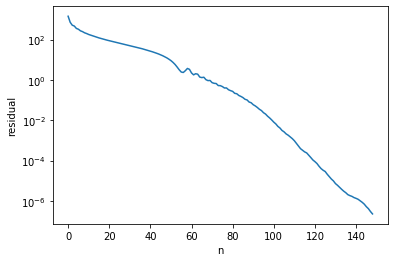

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(residuals)
ax.set_xlabel('n')
ax.set_ylabel('residual')

Below is the obvious solution plot. I have extended the solution plot to include the zero boundary conditions. This is nice to do, but not necessary in this case.

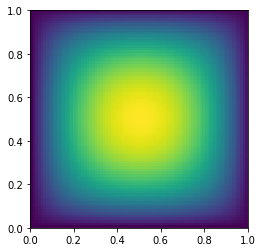

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

sol_with_bnd = np.zeros((m + 1, m + 1))
sol_with_bnd[1:m + 1, 1:m + 1] = sol.reshape(m, m)

ax.imshow(sol_with_bnd, extent=[0, 1, 0, 1], origin='lower')